<a href="https://colab.research.google.com/github/nicolas-garc/STATGR5243_Project1_FrogTail/blob/main/final_copy_of_Frog_and_tail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can frog grow its tail back?


In [ ]:
!pip install scanpy anndata scvi-tools leidenalg bbknn harmonypy magic-impute tabulate openpyxl igraph --quiet
import os
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, rand_score, silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings("ignore")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


/usr/local/lib/python3.12/dist-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Data accession

Load data from the link directly or load it through Courseworks .zip file.

In [ ]:
!wget https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/716/E-MTAB-7716/Files/arrayExpressUpload.zip -O /content/frogtail.zip

--2025-10-10 16:20:13--  https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/716/E-MTAB-7716/Files/arrayExpressUpload.zip
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94419121 (90M) [application/zip]
Saving to: ‘/content/frogtail.zip’

/content/frogtail.z 100%[===================>]  90.04M  20.6MB/s    in 5.8s    

2025-10-10 16:20:20 (15.6 MB/s) - ‘/content/frogtail.zip’ saved [94419121/94419121]



In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import zipfile
import os

zip_file = "/content/frogtail.zip" # replace path to your zip file's path
extract_dir = "/content/drive/MyDrive/TA/Frogtail_files/" # where zip file is going to be extracted to

os.makedirs(extract_dir, exist_ok=True) # create the extraction directory if it doesn't exist

with zipfile.ZipFile(zip_file, 'r') as zip_ref: # unzip
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to /content/drive/MyDrive/TA/Frogtail_files/


In [ ]:
zip_file = extract_dir+"ArrayExpressV2.zip" # file is a nested zip, dezip again

with zipfile.ZipFile(zip_file, 'r') as zip_ref: # unzip
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to /content/drive/MyDrive/TA/Frogtail_files/


In [ ]:
TABLE_S3_PATH = "/content/drive/MyDrive/aav9996_tables3.xlsx"

## Make an anndata matrix using scanpy or anndata

Usually single cell data is either directly stored in highdimensional files with .h5 extensions or in compressed count matrices with several tsv/csv/json logging the covariates information. Here is an example of how to compress and download this data into an anndata object that facilitates downstream single cell analysis.

- AnnData object for single cell data:  [Documentation](https://https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html)
- Scanpy for single cell analysis: [Documentation](https://scanpy.readthedocs.io/en/stable/index.html)



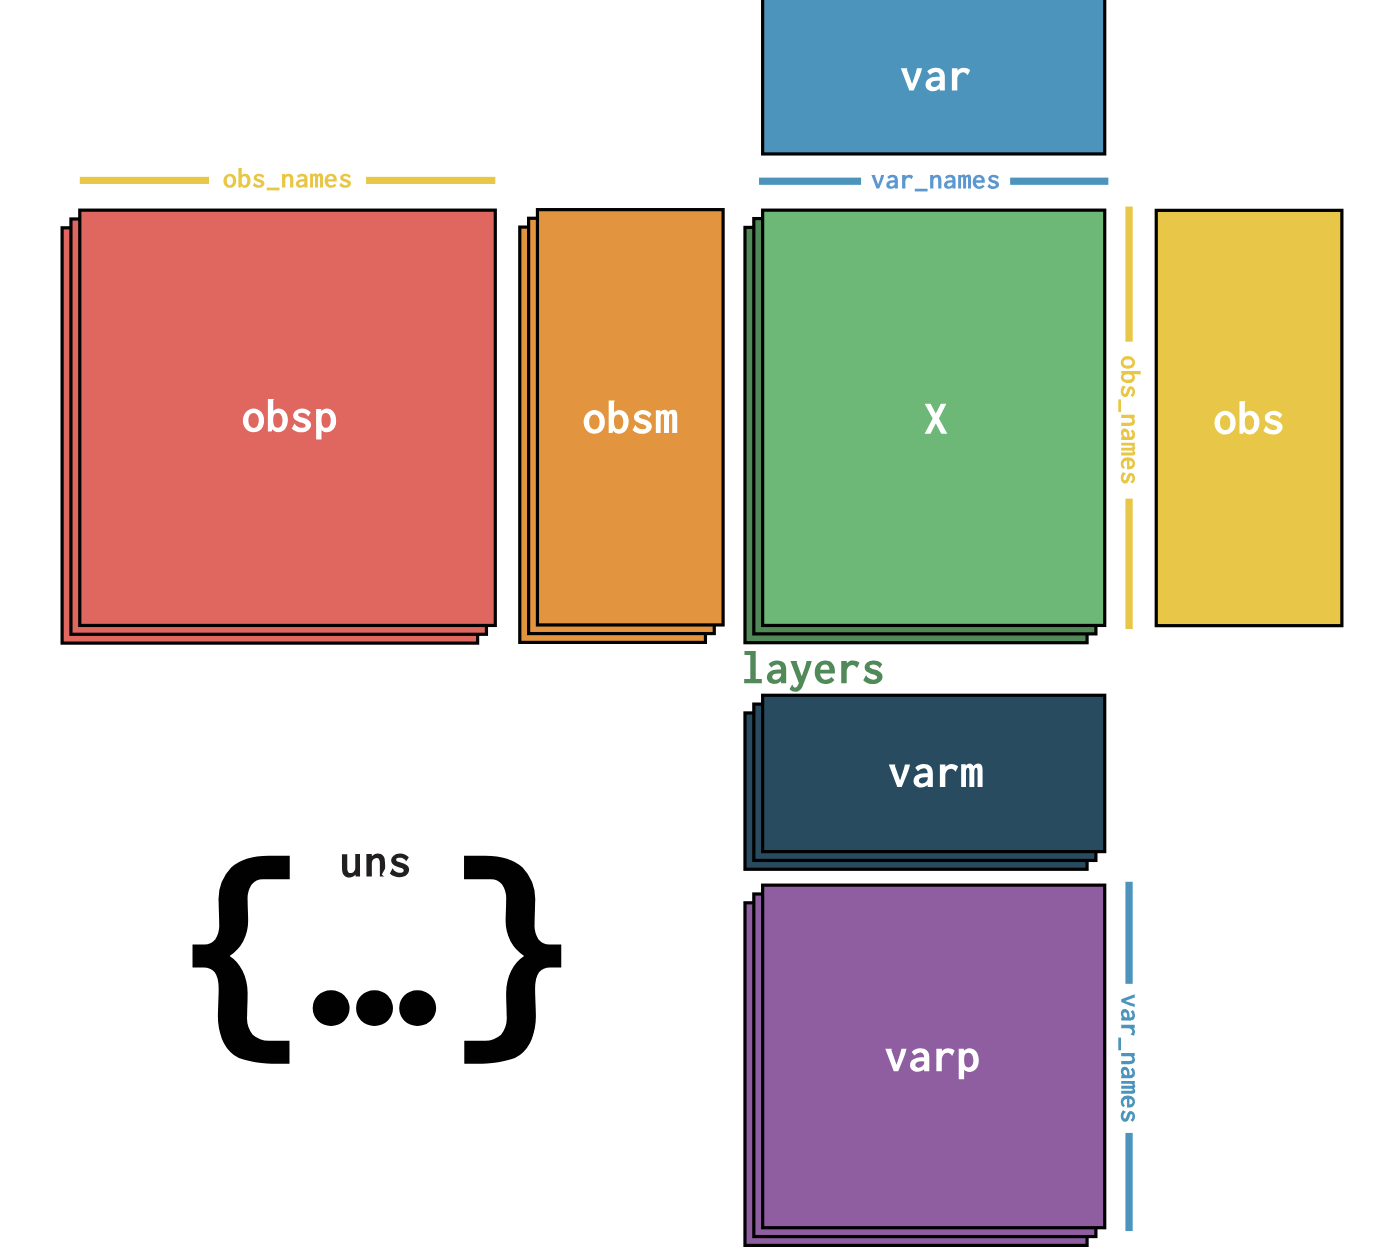

In [ ]:
!pip install igraph

In [ ]:
!pip install louvain
print('test')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for louvain: filename=louvain-0.8.2-cp312-cp312-linux_x86_64.whl size=971832 sha256=c65f808a50cfed834930c6007629a09eb970ac14883cba83e39468b09f959042
  Stored in directory: /root/.cache/pip/wheels/40/de/2b/bb7ed19d84727f9f299f20cd34c42bba9c8bef7d83d2255c86
Successfully built louvain
test


In [ ]:
!pip install leidenalg

In [ ]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from scipy.io import mmread


X = mmread(extract_dir+'ArrayExpress/countsMatrix.mtx') # compressed sparse matrix of gene expression
X = X.tocsr() # convert to sparse matrix
genes = pd.read_csv(extract_dir+'ArrayExpress/genes.csv', sep=' ', header=None) # col names of genes
cells = pd.read_csv(extract_dir+'ArrayExpress/cells.csv', sep=' ', header=None) # row names of cells
labels = pd.read_csv(extract_dir+'ArrayExpress/labels.csv')
meta = pd.read_csv(extract_dir+'ArrayExpress/meta.csv')


adata = ad.AnnData(X.T)

In [ ]:
cells.columns = ['barcode_cells']
meta_aug = pd.merge(meta, labels, left_on='sample', right_on='Sample', how='left')

In [ ]:
adata.var_names = genes[0]
adata.obs = pd.merge(cells, meta_aug, left_on='barcode_cells', right_on='cell')


In [ ]:
adata

AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

In [ ]:
adata.var

""
Xelaev18000001m.g
Xelaev18000003m.g
Xelaev18000004m.g
Xelaev18000005m.g
tm6sf2.1
...
loc101731491.S
loc101731436.S
Xetrov90022661m.S
loc398467.S


In [ ]:
adata.X = adata.X.tocsr()

In [ ]:
adata.write_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad')

## Load data

In [ ]:
import anndata as ad
extract_dir = "/content/drive/MyDrive/TA"
adata = ad.read_h5ad('/content/drive/MyDrive/TA/Frogtail_files/cleaned_processed_frogtail.h5ad') # ad.read_h5ad()

In [ ]:
adata.X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
adata.obs

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13194,TTCTTAGAGTACCGGA.1,TTCTTAGAGTACCGGA.1,SIGAB10,st40,3,Erythrocyte 4,-5.879582,0.924197,G2M,SIGAB10,SLX-15739,ST40_3,4
13195,TTGACTTAGAGTAAGG.1,TTGACTTAGAGTAAGG.1,SIGAB10,st40,3,Goblet cell,1.252149,-8.870151,G1,SIGAB10,SLX-15739,ST40_3,4
13196,TTGCGTCTCAAGAAGT.1,TTGCGTCTCAAGAAGT.1,SIGAB10,st40,3,Goblet cell,0.693335,-9.168521,G1,SIGAB10,SLX-15739,ST40_3,4
13197,TTGTAGGCAGTACACT.1,TTGTAGGCAGTACACT.1,SIGAB10,st40,3,Erythrocyte 1,-4.087618,4.145738,G1,SIGAB10,SLX-15739,ST40_3,4


In [ ]:
adata

AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

In [ ]:
adata.X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
adata.obs

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13194,TTCTTAGAGTACCGGA.1,TTCTTAGAGTACCGGA.1,SIGAB10,st40,3,Erythrocyte 4,-5.879582,0.924197,G2M,SIGAB10,SLX-15739,ST40_3,4
13195,TTGACTTAGAGTAAGG.1,TTGACTTAGAGTAAGG.1,SIGAB10,st40,3,Goblet cell,1.252149,-8.870151,G1,SIGAB10,SLX-15739,ST40_3,4
13196,TTGCGTCTCAAGAAGT.1,TTGCGTCTCAAGAAGT.1,SIGAB10,st40,3,Goblet cell,0.693335,-9.168521,G1,SIGAB10,SLX-15739,ST40_3,4
13197,TTGTAGGCAGTACACT.1,TTGTAGGCAGTACACT.1,SIGAB10,st40,3,Erythrocyte 1,-4.087618,4.145738,G1,SIGAB10,SLX-15739,ST40_3,4


## Processing data

In [ ]:
adata.layers["counts"] = adata.X.copy()


In [ ]:
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.highly_variable_genes(adata, n_top_genes=2300)

In [ ]:
hvg = adata.var["highly_variable"].to_numpy()
adata.obsm["X_log2_hvg"] = adata[:, hvg].X


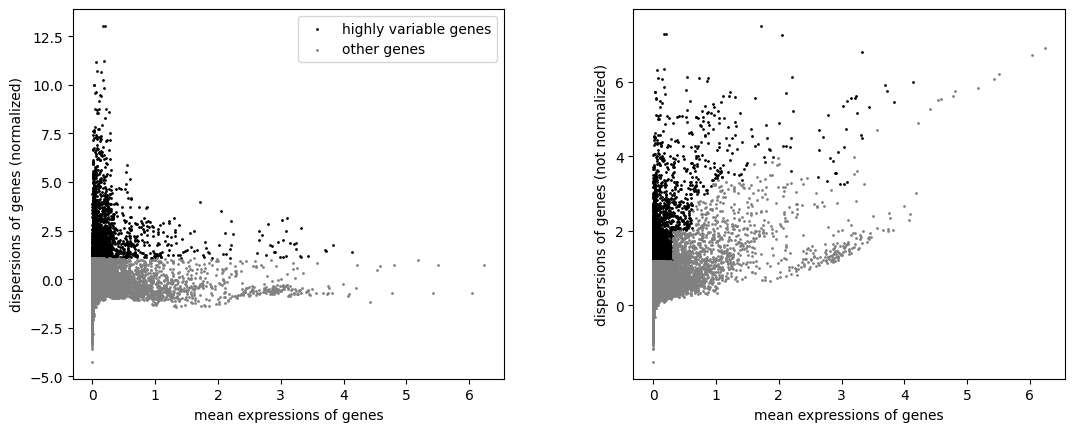

In [ ]:
sc.pl.highly_variable_genes(adata)

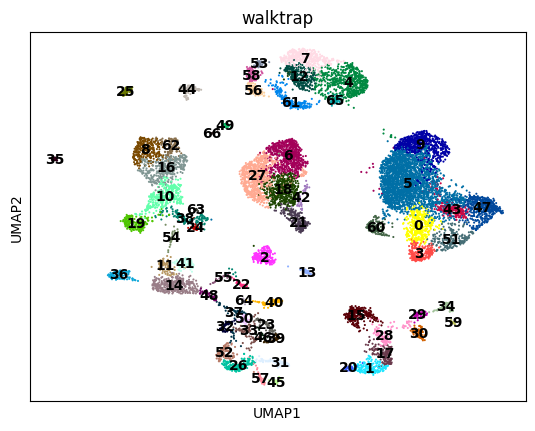

KeyError: 'tp63'

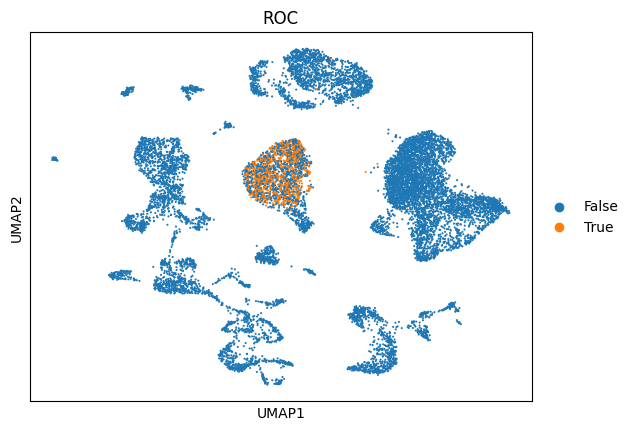

In [ ]:
# --- Paper-faithful processing for Xenopus ROC analysis (Aztekin et al. 2019) ---
'''
import scanpy as sc, anndata as ad
import numpy as np, pandas as pd, scipy.sparse as sp
from umap.umap_ import fuzzy_simplicial_set
import igraph as ig
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import hypergeom

# 0) Utilities
def to_dense(x):
    # Use .toarray() for sparse matrices to convert to dense numpy array
    return x.toarray() if sp.issparse(x) else x

def lower_varnames(adata):
    adata.var_names = pd.Index([g.lower() for g in adata.var_names])
    return adata

def tpx_and_log2(adata, target_sum=1e4):
    # total-count normalize to TPX (per 1e4) then log2(1 + TPX)
    sc.pp.normalize_total(adata, target_sum=target_sum)
    X = to_dense(adata.X)
    X_log2 = np.log2(1.0 + X)
    adata.layers["log2"] = X_log2
    adata.X = X_log2  # use log2 for downstream steps (as in paper)
    return adata

def hvg_faithful(adata):
    # emulate: keep genes with mean in [5th, 80th] percentiles; HVGs by dispersion/Fano > 65th pct
    X = to_dense(adata.X)
    gmean = X.mean(axis=0)
    # dispersion (variance/mean); add eps to avoid div-by-zero
    gvar  = X.var(axis=0, ddof=0)
    disp  = gvar / (gmean + 1e-8)

    p5, p80 = np.percentile(gmean, [5, 80])
    keep_mean = (gmean >= p5) & (gmean <= p80)

    disp_keep = disp[keep_mean]
    thr65 = np.percentile(disp_keep, 65)
    hvg_mask = np.zeros(adata.n_vars, dtype=bool)
    idx = np.where(keep_mean)[0]
    hvg_mask[idx] = disp_keep >= thr65

    adata.var["highly_variable"] = hvg_mask
    return adata

def build_umap_and_graph(adata, n_pcs=50, umap_k=20, umap_min_dist=0.5, graph_k=10):
    # PCA (for speed/stability)
    sc.tl.pca(adata, n_comps=n_pcs, svd_solver="arpack")
    # UMAP for visualization (cosine, k=20, min_dist=0.5)
    sc.pp.neighbors(adata, n_neighbors=umap_k, n_pcs=n_pcs, metric="cosine")
    sc.tl.umap(adata, min_dist=umap_min_dist)
    # Fuzzy simplicial set (cosine, k=10) for clustering graph
    X = adata.obsm["X_pca"]
    n_neighbors = graph_k
    # UMAP expects (n_samples, n_features)
    graph, sigmas, rhos = fuzzy_simplicial_set(
        X, n_neighbors=n_neighbors, random_state=0, metric="cosine"
    )
    adata.obsp["connectivities_fuzzy"] = graph.tocsr()
    return adata

def walktrap_cluster(adata, graph_key="connectivities_fuzzy", steps=10, label_key="walktrap"):
    G = adata.obsp[graph_key].tocsr()
    G = G.maximum(G.T)  # symmetrize
    sources, targets = G.nonzero()
    weights = G[sources, targets].A1
    g = ig.Graph(n=G.shape[0], edges=list(zip(sources, targets)), edge_attrs={"weight": weights}, directed=False)
    clusters = g.community_walktrap(weights="weight", steps=steps).as_clustering()
    labels = np.array(clusters.membership).astype(str)
    adata.obs[label_key] = labels
    return adata

def subset_skin(adata):
    if "cluster" not in adata.obs:
        return adata.copy()
    skin_like = adata.obs["cluster"].astype(str).str.contains(
        "skin|epiderm|goblet|ionocyte|keratin|multicili|epitheli", case=False, regex=True
    )
    sub = adata[skin_like].copy()
    return sub if sub.n_obs >= 300 else adata.copy()

def find_gene_any_allele(adata, base):
    """Find gene name matching base, ignoring case and .L/.S suffixes."""
    base_lower = base.lower()
    candidates = []
    for name in adata.var_names:
        name_lower = name.lower()
        if name_lower == base_lower or name_lower == f"{base_lower}.l" or name_lower == f"{base_lower}.s":
            candidates.append(name)
        elif name_lower.split('.')[0] == base_lower:
             candidates.append(name)
    return candidates


def call_ROC(adata, tp_base="tp63", lf_base="lef1", pct=75):
    skin = subset_skin(adata)
    tp_genes = find_gene_any_allele(skin, tp_base)
    lf_genes = find_gene_any_allele(skin, lf_base)
    if not tp_genes or not lf_genes:
        raise ValueError(f"Could not find {tp_base} or {lf_base} alleles in var_names.")
    tp = to_dense(skin[:, tp_genes].X).max(axis=1)  # any allele
    lf = to_dense(skin[:, lf_genes].X).max(axis=1)
    tp_thr = np.percentile(tp, pct)
    lf_thr = np.percentile(lf, pct)
    mask_skin = (tp >= tp_thr) & (lf >= lf_thr)

    roc_flag = pd.Series(False, index=adata.obs_names)
    roc_flag.loc[skin.obs_names[mask_skin]] = True
    adata.obs["ROC"] = roc_flag.values
    return adata

def rank_markers_two(adata, group="ROC", n_top=50):
    # ROC vs rest using Wilcoxon and LogReg on paper-faithful X (log2)
    sc.tl.rank_genes_groups(adata, groupby=group, groups=["True"], reference="rest",
                            method="wilcoxon", key_added="rg_wilc")
    sc.tl.rank_genes_groups(adata, groupby=group, groups=["True"], reference="rest",
                            method="logreg",  key_added="rg_logreg")
    def topn(key):
        d = sc.get.rank_genes_groups_df(adata, group="True", key=key)
        return d.sort_values("scores", ascending=False).head(n_top)["names"].str.lower().tolist()
    return topn("rg_wilc"), topn("rg_logreg")

def metrics_table(adata, label_keys=("walktrap",), emb="X_pca"):
    X = adata.obsm[emb]
    rows = []
    for k in label_keys:
        y = adata.obs[k].astype(str)
        rows.append(dict(alg=k,
                         silhouette=float(silhouette_score(X, y)),
                         calinski_harabasz=float(calinski_harabasz_score(X, y)),
                         davies_bouldin=float(davies_bouldin_score(X, y))))
    return pd.DataFrame(rows)

def load_tableS3_genes(xlsx_path):
    xls = pd.ExcelFile(xlsx_path)
    out = set()
    for sh in xls.sheet_names:
        df = pd.read_excel(xlsx_path, sheet_name=sh)
        for col in df.columns:
            if "roc" in str(col).lower():
                vals = pd.Series(df[col].dropna()).astype(str).str.strip().str.lower()
                out |= set([v for v in vals if v and v != "nan"])
    return sorted(out)

def compare_to_tableS3(my_genes, ref_genes):
    A, B = set(my_genes), set(ref_genes)
    M = len(A|B); N = len(A); n = len(B); k = len(A&B)
    pv = hypergeom.sf(k-1, M, n, N)
    return dict(k=k, N=N, n=n, M=M, pval=float(pv),
                precision=k/max(1,N), recall=k/max(1,n), jaccard=k/max(1,len(A|B)))

# 1) Start from your existing AnnData
adata = lower_varnames(adata)
adata.layers["counts"] = adata.X.copy()

# 2) Paper-faithful normalization + log2
adata = tpx_and_log2(adata)

# 3) HVGs (Fano/dispersion > 65th pct, with mean filters)
adata = hvg_faithful(adata)
adata_hvg = adata[:, adata.var["highly_variable"]].copy()

# 4) PCA, UMAP (cosine; k=20; min_dist=0.5), and fuzzy graph (cosine; k=10)
adata_hvg = build_umap_and_graph(adata_hvg, n_pcs=50, umap_k=20, umap_min_dist=0.5, graph_k=10)

# Transfer UMAP coordinates from adata_hvg to adata for plotting
adata.obsm["X_umap"] = adata_hvg.obsm["X_umap"]


# 5) Walktrap clustering (steps=10)
adata_hvg = walktrap_cluster(adata_hvg, graph_key="connectivities_fuzzy", steps=10, label_key="walktrap")

# 6) Map labels back to full object for plotting convenience
adata.obs["walktrap"] = pd.Categorical(adata_hvg.obs["walktrap"], categories=None)


# 7) Identify ROCs in skin: TP63+/LEF1+ with allele-aware gating (top quartile)
adata = call_ROC(adata)

# 8) Visuals (UMAP colored by clusters/ROC)
sc.pl.umap(adata_hvg, color=["walktrap"], legend_loc="on data")
sc.pl.umap(adata, color=["ROC", "tp63", "lef1"], wspace=0.3)

# 9) Clustering metrics (internal)
m = metrics_table(adata_hvg, label_keys=("walktrap",))
print(m)

# 10) Marker finding for ROC vs rest (Wilcoxon + LogReg), and Table S3 overlap
wilc_top, logr_top = rank_markers_two(adata, group="ROC", n_top=50)
print("Top ROC markers (Wilcoxon) :", wilc_top[:15])
print("Top ROC markers (LogReg)   :", logr_top[:15])

# If you uploaded Table S3 (XLSX), point to it here:
TABLE_S3_PATH = "/content/aav9996_tables3.xlsx"  # <- change if needed
try:
    roc_ref = load_tableS3_genes(TABLE_S3_PATH)
    print(f"Loaded {len(roc_ref)} ROC genes from Table S3.")
    print("Overlap vs S3 (Wilcoxon):", compare_to_tableS3(wilc_top, roc_ref))
    print("Overlap vs S3 (LogReg)  :", compare_to_tableS3(logr_top, roc_ref))
except Exception as e:
    print("[Note] Could not read Table S3:", e)'''

Internal metrics:
                  alg  silhouette  calinski_harabasz  davies_bouldin
1   clust_leiden_r0.6    0.274826        1843.025269        1.176394
5    clust_kmeans_k26    0.269782        2213.177246        1.307171
3  clust_louvain_r0.6    0.267166        1792.373413        1.142131
4  clust_louvain_r1.0    0.225802        1798.403931        1.233889
2   clust_leiden_r1.0    0.225208        1846.914429        1.181742
0            walktrap    0.184203        1215.335693        1.379959

Pairwise ARI/Rand/NMI between clusterings:
                                        pair       ARI      Rand       NMI
6    clust_leiden_r0.6 vs clust_louvain_r0.6  0.948153  0.990733  0.954264
10   clust_leiden_r1.0 vs clust_louvain_r1.0  0.804280  0.977769  0.917883
8      clust_leiden_r0.6 vs clust_kmeans_k26  0.749334  0.955268  0.844001
13    clust_louvain_r0.6 vs clust_kmeans_k26  0.739370  0.952838  0.834816
5     clust_leiden_r0.6 vs clust_leiden_r1.0  0.722920  0.959610  0.918096
12  c

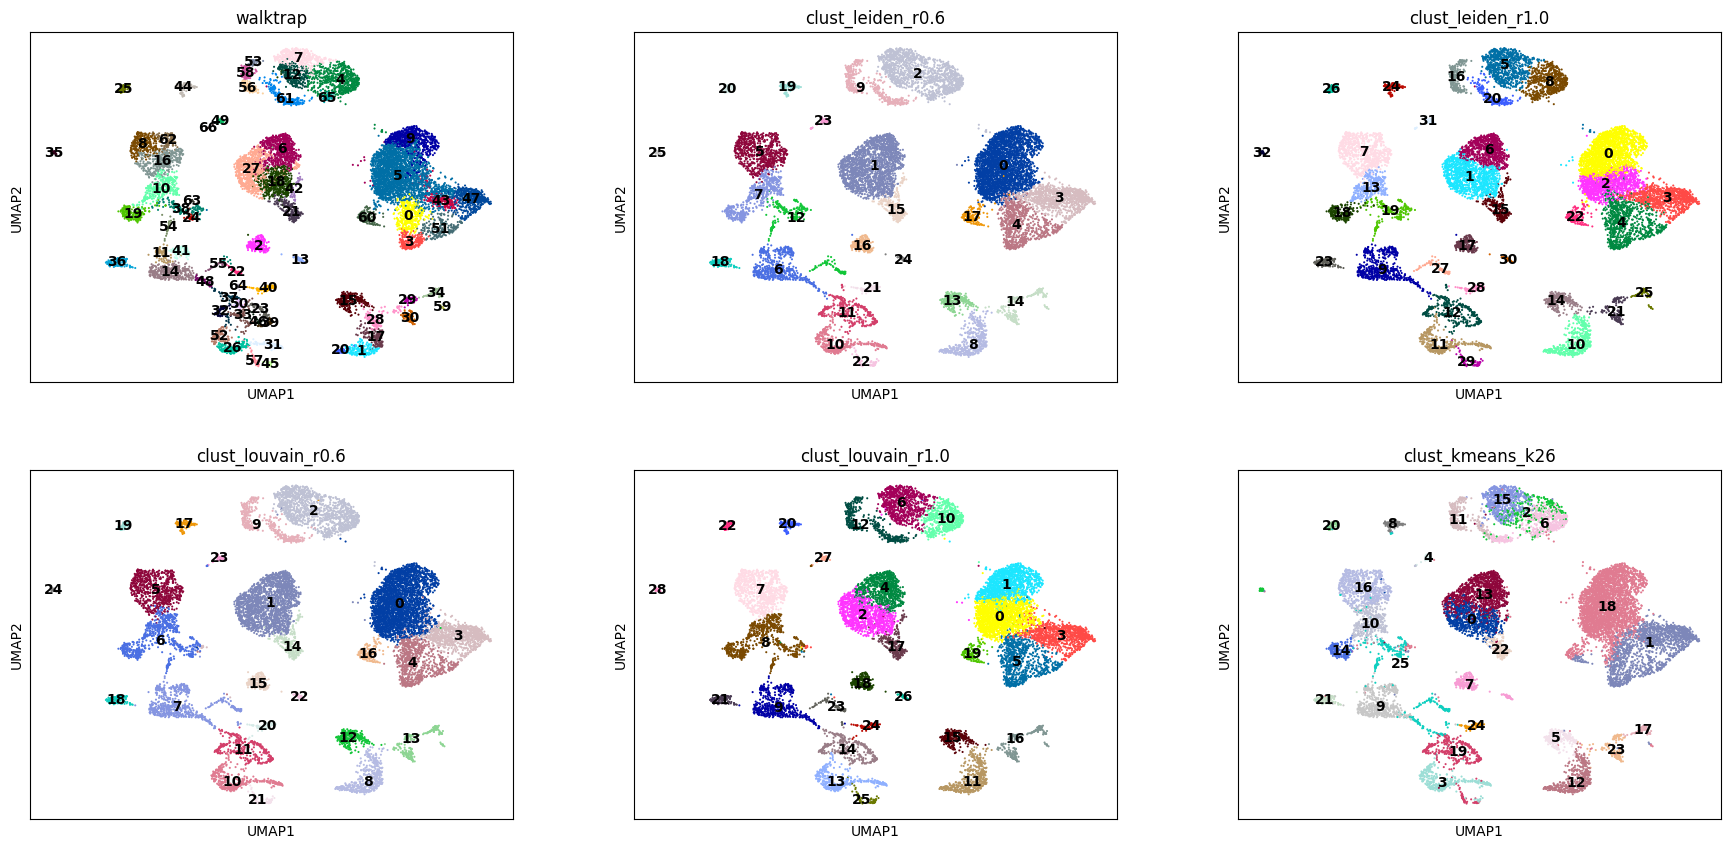

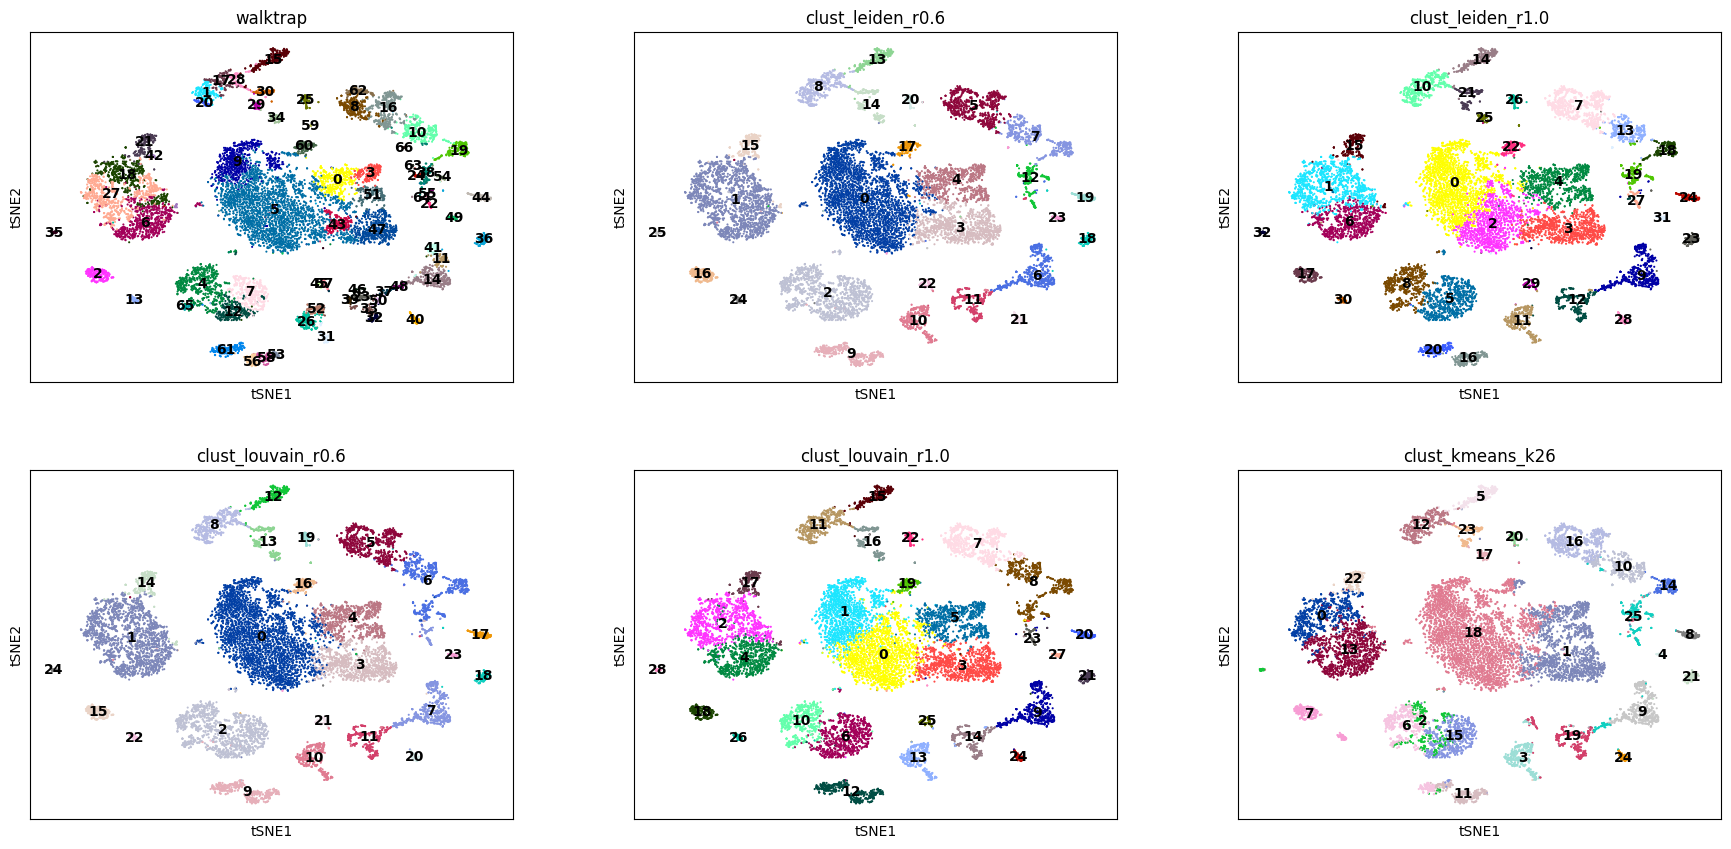

In [ ]:
# ===========================
# CLUSTERING: +Leiden +Louvain +KMeans, metrics & pairwise comparisons
# ===========================
import scanpy as sc
import numpy as np, pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, rand_score, normalized_mutual_info_score
)

def add_more_clusterings(adata_hvg, n_pcs=50, kmeans_k=None,
                         leiden_res=(0.6, 1.0), louvain_res=(1.0,),
                         key_prefix="clust"):
    """
    Adds Leiden/Louvain/KMeans labels to adata_hvg.obs.
    Requires neighbors to be computed already (you already do via build_umap_and_graph).
    """
    # Leiden at multiple resolutions
    for r in leiden_res:
        key = f"{key_prefix}_leiden_r{r}"
        sc.tl.leiden(adata_hvg, resolution=r, key_added=key)

    # Louvain at multiple resolutions
    for r in louvain_res:
        key = f"{key_prefix}_louvain_r{r}"
        sc.tl.louvain(adata_hvg, resolution=r, key_added=key)

    # Optional: KMeans in PCA space for non-graph clustering
    if kmeans_k is None:
        # heuristic: ~ #clusters from a medium-resolution Leiden
        probe = f"{key_prefix}_leiden_r{leiden_res[0]}"
        kmeans_k = adata_hvg.obs[probe].astype(str).nunique() if probe in adata_hvg.obs else 8
    km = KMeans(n_clusters=int(kmeans_k), n_init=10, random_state=0)
    labels = km.fit_predict(adata_hvg.obsm["X_pca"][:, :n_pcs])
    adata_hvg.obs[f"{key_prefix}_kmeans_k{kmeans_k}"] = pd.Categorical(labels.astype(str))

    return adata_hvg

def clustering_internal_metrics(adata_hvg, label_keys, emb="X_pca"):
    X = adata_hvg.obsm[emb]
    rows = []
    for k in label_keys:
        y = adata_hvg.obs[k].astype(str)
        rows.append(dict(
            alg=k,
            silhouette=float(silhouette_score(X, y)),
            calinski_harabasz=float(calinski_harabasz_score(X, y)),
            davies_bouldin=float(davies_bouldin_score(X, y)),
        ))
    return pd.DataFrame(rows)

def clustering_pairwise_metrics(adata_hvg, label_keys):
    """
    Pairwise ARI, Rand, and NMI between any two cluster labelings.
    """
    rows = []
    for i in range(len(label_keys)):
        for j in range(i+1, len(label_keys)):
            k1, k2 = label_keys[i], label_keys[j]
            y1 = adata_hvg.obs[k1].astype(str).values
            y2 = adata_hvg.obs[k2].astype(str).values
            rows.append(dict(
                pair=f"{k1} vs {k2}",
                ARI=float(adjusted_rand_score(y1, y2)),
                Rand=float(rand_score(y1, y2)),
                NMI=float(normalized_mutual_info_score(y1, y2))
            ))
    return pd.DataFrame(rows)

# --- Run the new clusterers (neighbors are already built by your build_umap_and_graph)
adata_hvg = add_more_clusterings(
    adata_hvg,
    n_pcs=50,
    leiden_res=(0.6, 1.0),   # tweak if you want more/fewer clusters
    louvain_res=(0.6, 1.0),
    key_prefix="clust"
)

cluster_keys = [
    "walktrap",
    "clust_leiden_r0.6", "clust_leiden_r1.0",
    "clust_louvain_r0.6", "clust_louvain_r1.0",
    # this key was added by add_more_clusterings with auto K
    [k for k in adata_hvg.obs.columns if k.startswith("clust_kmeans_k")][0],
]

# Internal metrics (you already had some; here we collect for all)
internal_df = clustering_internal_metrics(adata_hvg, cluster_keys, emb="X_pca")
print("Internal metrics:")
print(internal_df.sort_values("silhouette", ascending=False))

# Pairwise metrics across clusterings
pairwise_df = clustering_pairwise_metrics(adata_hvg, cluster_keys)
print("\nPairwise ARI/Rand/NMI between clusterings:")
print(pairwise_df.sort_values("ARI", ascending=False))

# Quick visuals
sc.pl.umap(adata_hvg, color=cluster_keys, ncols=3, legend_loc="on data")
sc.tl.tsne(adata_hvg, use_rep="X_pca", perplexity=30, n_pcs=50, random_state=0)
sc.pl.tsne(adata_hvg, color=cluster_keys, ncols=3, legend_loc="on data")


In [ ]:
import pandas as pd
import scanpy as sc

# 0) Pick the clustering you want to use for DE
cluster_key = "clust_leiden_r1.0"   # <-- put your real column name here

# 1) Make a DE-ready view: drop cells without a label (joins often create NaNs)
lab_ok = cluster_key in adata_hvg.obs and ~adata_hvg.obs[cluster_key].isna()
adata_de = adata_hvg[lab_ok].copy()

# 2) Ensure categorical labels + at least 2 clusters with some cells
if not pd.api.types.is_categorical_dtype(adata_de.obs[cluster_key]):
    adata_de.obs[cluster_key] = adata_de.obs[cluster_key].astype(str).astype("category")
counts = adata_de.obs[cluster_key].value_counts()
assert len(counts) >= 2 and (counts >= 5).all(), f"Bad labels for DE: {dict(counts)}"

# 3) Make sure use_raw=True points to a normalized matrix
if adata_de.raw is None:
    adata_de.raw = adata_de.copy()   # use whatever you normalized/logged

# 4) Run Wilcoxon + Logistic Regression (per cluster vs rest)
sc.tl.rank_genes_groups(adata_de, groupby=cluster_key, method="wilcoxon",
                        n_genes=200, use_raw=True, key_added="de_wilc")
sc.tl.rank_genes_groups(adata_de, groupby=cluster_key, method="logreg",
                        n_genes=200, use_raw=True, key_added="de_logr")

df_w = sc.get.rank_genes_groups_df(adata_de, group=None, key="de_wilc")
df_l = sc.get.rank_genes_groups_df(adata_de, group=None, key="de_logr")

# 5) Top-N per cluster (robust to different columns)
def topn_by_cluster(rg_df, topn=50):
    key = "pvals_adj" if "pvals_adj" in rg_df.columns else \
          ("scores" if "scores" in rg_df.columns else "logfoldchanges")
    asc = (key == "pvals_adj")
    out = {}
    for g in sorted(rg_df["group"].unique(),
                    key=lambda x: int(x) if str(x).isdigit() else str(x)):
        sub = rg_df[rg_df["group"] == g].sort_values(key, ascending=asc)
        out[str(g)] = sub["names"].head(topn).astype(str).tolist()
    return out

wilcox_top = topn_by_cluster(df_w, 50)
logreg_top = topn_by_cluster(df_l, 50)

print("Example cluster tops:")
some = sorted(wilcox_top.keys(), key=lambda x: int(x) if x.isdigit() else x)[:3]
for c in some:
    print(f"• cluster {c} (wilcoxon):", wilcox_top[c][:8])
    print(f"• cluster {c} (logreg)  :", logreg_top[c][:8])


Example cluster tops:
• cluster 0 (wilcoxon): ['Xelaev18045099m.g', 'Xelaev18002241m.g', 'hbd.S', 'rfesd.L', 'nmrk2.S', 'ca2.L', 'alas2.S', 'lmo2.S']
• cluster 0 (logreg)  : ['Xelaev18040563m.g', 'creg1.L', 'loc100493672.L', 'Xelaev18046765m.g', 'znf577.S', 'eepd1.L', 'fbxo7.S', 'Xelaev18047455m.g']
• cluster 1 (wilcoxon): ['lum.L', 'c2orf40.L', 'lum.S', 's100a11.L', 'mdk.L', 'col17a1.L', 'fgfbp2.L', 'mdk.S']
• cluster 1 (logreg)  : ['mdk.L', 'krt5.7.S', 'mmp8.L', 'postn.S', 'enpp2.S', 'egfl6.S', 'col14a1.S', 'postn.L']
• cluster 2 (wilcoxon): ['hbd.L', 'hbd.S', 'Xelaev18045098m.g', 'Xelaev18047455m.g', 'ca2.L', 'prdx2.L', 'Xelaev18045099m.g', 'nmrk2.L']
• cluster 2 (logreg)  : ['Xelaev18045098m.g', 'hbd.S', 'sub1.S', 'Xelaev18002241m.g', 'tspo.L', 'eif2s2.L', 'Xelaev18045525m.g', 'Xelaev18007558m.g']


In [ ]:
import os, pandas as pd, numpy as np
from scipy.stats import hypergeom

TABLE_S3_PATH = "/content/drive/MyDrive/aav9996_tables3.xlsx"  # your path

def _norm_gene(g):
    return str(g).replace(".L","").replace(".S","").strip().upper()

def load_table_s3_roc_genes(xlsx_path):
    assert os.path.exists(xlsx_path), f"Excel not found: {xlsx_path}"
    xl = pd.ExcelFile(xlsx_path)
    roc = set()
    for sh in xl.sheet_names:
        df = pd.read_excel(xlsx_path, sheet_name=sh)
        # prefer columns whose header mentions 'roc'; else fallback to the first column
        cols = [c for c in df.columns if "roc" in str(c).lower()] or [df.columns[0]]
        for c in cols:
            vals = pd.Series(df[c]).dropna().astype(str)
            vals = vals[vals.str.strip().str.len() > 0]
            roc |= {_norm_gene(x) for x in vals}
    return {g for g in roc if g not in {"", "NAN"}}


def overlap_stats_per_cluster_robust(top_dict, ref_genes_set, adata_varnames, universe_size=None):
    """
    top_dict: {cluster -> [genes]} from Wilcoxon/LogReg (any case/format)
    ref_genes_set: harmonized ROC genes from Table S3 (uppercased, suffix-stripped)
    adata_varnames: the AnnData.var_names you used for DE
    """
    # Universe = unique harmonized genes present in your data
    M = universe_size if universe_size is not None else len({_norm_gene(v) for v in adata_varnames})
    K = len(ref_genes_set)
    rows = []
    for cl, genes in top_dict.items():
        # Harmonize your markers directly
        hset = {_norm_gene(g) for g in genes if isinstance(g, str)}
        n = len(hset)
        k = len(hset & ref_genes_set)
        # P(X >= k)
        pval = hypergeom.sf(max(0, k-1), M, K, n) if n > 0 else 1.0
        jacc = k / max(1, len(hset | ref_genes_set))
        rows.append({
            "cluster": str(cl),
            "k_overlap": int(k),
            "n_cluster_top": int(n),
            "K_ref": int(K),
            "M_universe": int(M),
            "pval_hypergeom": float(pval),
            "jaccard": float(jacc),
        })
    return pd.DataFrame(rows).sort_values(["k_overlap", "jaccard"], ascending=False)


In [ ]:
ref_roc = load_table_s3_roc_genes(TABLE_S3_PATH)          # your existing loader
overlap_wilcox = overlap_stats_per_cluster_robust(wilcox_top, ref_roc, adata.var_names)
overlap_logreg = overlap_stats_per_cluster_robust(logreg_top, ref_roc, adata.var_names)
display(overlap_wilcox.head(10))
display(overlap_logreg.head(10))


,cluster,k_overlap,n_cluster_top,K_ref,M_universe,pval_hypergeom,jaccard
4,4,8,45,197,26166,1.520121e-09,0.034188
15,15,5,43,197,26166,1.754170e-05,0.021277
23,23,2,41,197,26166,3.816652e-02,0.008475
3,3,2,45,197,26166,4.519235e-02,0.008333
18,18,2,47,197,26166,4.887019e-02,0.008264
6,6,1,38,197,26166,2.497756e-01,0.004274
1,1,1,41,197,26166,2.666182e-01,0.004219
13,13,1,42,197,26166,2.721484e-01,0.004202
17,17,1,42,197,26166,2.721484e-01,0.004202
29,29,1,42,197,26166,2.721484e-01,0.004202


,cluster,k_overlap,n_cluster_top,K_ref,M_universe,pval_hypergeom,jaccard
4,4,12,42,197,26166,2.146659e-16,0.052863
15,15,5,44,197,26166,1.967027e-05,0.021186
19,19,4,43,197,26166,3.056494e-04,0.016949
23,23,2,42,197,26166,3.988045e-02,0.008439
18,18,2,47,197,26166,4.887019e-02,0.008264
32,32,1,42,197,26166,2.721484e-01,0.004202
29,29,1,43,197,26166,2.776371e-01,0.004184
26,26,1,44,197,26166,2.830846e-01,0.004167
1,1,1,45,197,26166,2.884913e-01,0.004149
30,30,1,45,197,26166,2.884913e-01,0.004149


In [ ]:
import numpy as np
import pandas as pd

def _minmax01(x):
    """Min–max to [0,1] that works on Series/arrays; safe for constant vectors."""
    x = pd.Series(x).astype(float)
    lo, hi = x.min(), x.max()
    rng = hi - lo
    if rng <= 0 or not np.isfinite(rng):
        return pd.Series(np.zeros(len(x), dtype=float), index=x.index)
    return (x - lo) / rng

def pick_consensus_cluster(ow: pd.DataFrame, ol: pd.DataFrame, weight_p=0.7, weight_k=0.3):
    """
    Blend -log10(p) and k_overlap within each method (Wilcoxon/LogReg), normalize to [0,1],
    then sum scores across methods and pick the best cluster.
    Expects columns: ['cluster','k_overlap','pval_hypergeom'].
    """
    req = {"cluster","k_overlap","pval_hypergeom"}

    def _score(df):
        if not req.issubset(df.columns):
            missing = req - set(df.columns)
            raise ValueError(f"Input DF missing columns: {missing}")
        s = df[["cluster","k_overlap","pval_hypergeom"]].copy()
        # make sure cluster is string for merges/keys
        s["cluster"] = s["cluster"].astype(str)
        # robust -log10 p (avoid inf)
        s["neglog10p"] = -np.log10(s["pval_hypergeom"].astype(float) + 1e-300)
        # normalize per-method
        s["neglog10p_z"] = _minmax01(s["neglog10p"])
        s["k_z"] = _minmax01(s["k_overlap"].astype(float))
        s["score"] = weight_p * s["neglog10p_z"] + weight_k * s["k_z"]
        return s[["cluster","score"]]

    sw = _score(ow).rename(columns={"score":"score_w"})
    sl = _score(ol).rename(columns={"score":"score_l"})
    sc = pd.merge(sw, sl, on="cluster", how="outer").fillna(0.0)
    sc["score_sum"] = sc["score_w"] + sc["score_l"]
    sc = sc.sort_values("score_sum", ascending=False, key=lambda c: c.astype(float) if c.name=="cluster" and pd.api.types.is_numeric_dtype(pd.Series(sc["cluster"]).astype(str).str.isnumeric()) else c)
    best = str(sc.iloc[0]["cluster"])
    return best, sc

# usage
best_cluster, score_table = pick_consensus_cluster(overlap_wilcox, overlap_logreg)
print("Consensus ROC cluster:", best_cluster)
display(score_table.head(10))


Consensus ROC cluster: 4


,cluster,score_w,score_l,score_sum
27,4,1.000000,1.000000,2.000000
7,15,0.544974,0.319052,0.864026
16,23,0.151045,0.091421,0.242466
11,19,0.001974,0.239063,0.241037
10,18,0.141993,0.087346,0.229339
23,3,0.144858,0.026028,0.170885
22,29,0.041610,0.027526,0.069135
1,1,0.042361,0.026757,0.069118
19,26,0.040878,0.027136,0.068015
24,30,0.040878,0.026757,0.067635


In [ ]:
# You already harmonized Table S3 to `ref_roc` (UPPER, no .L/.S)
# and you have your per-cluster top lists from both methods:
# wilcox_top: {cluster -> [gene names as in adata.var_names]}
# logreg_top: {cluster -> [ ... ]}

def _norm_gene(g):  # same normalizer you used earlier
    return str(g).replace(".L","").replace(".S","").strip().upper()

def overlap_gene_lists(cluster_id, wilcox_top, logreg_top, ref_roc):
    w = set(_norm_gene(g) for g in wilcox_top.get(str(cluster_id), []))
    l = set(_norm_gene(g) for g in logreg_top.get(str(cluster_id), []))
    # union of your method-specific tops, intersect with reference
    consens = (w | l) & ref_roc
    return sorted(consens), sorted(w & ref_roc), sorted(l & ref_roc)

cons_all, cons_w, cons_l = overlap_gene_lists(best_cluster, wilcox_top, logreg_top, ref_roc)
print(f"\nOverlapping ROC genes for cluster {best_cluster}: {len(cons_all)}")
print(cons_all[:30])  # show a sample



Overlapping ROC genes for cluster 4: 14
['AURKB', 'CDC20', 'CDK1', 'CENPA', 'CENPF', 'CKAP2', 'CKS2', 'HMGB2', 'KIF2C', 'MKI67', 'NDC80', 'SMC4', 'TMPO', 'UBE2C']


In [ ]:
# Map harmonized -> original var names that match
def original_names_from_harmonized(adata, harmonized_list):
    norm = {_norm_gene(v): v for v in adata.var_names}
    out = []
    for h in harmonized_list:
        # there may be multiple originals mapping to same normalized symbol
        out.extend([orig for orig in adata.var_names if _norm_gene(orig) == h])
    # keep unique, preserve order
    seen = set(); ordered = []
    for g in out:
        if g not in seen:
            seen.add(g); ordered.append(g)
    return ordered

plot_genes = original_names_from_harmonized(adata, cons_all)[:8]  # pick up to 8 to visualize
print("Genes to plot:", plot_genes)


Genes to plot: []


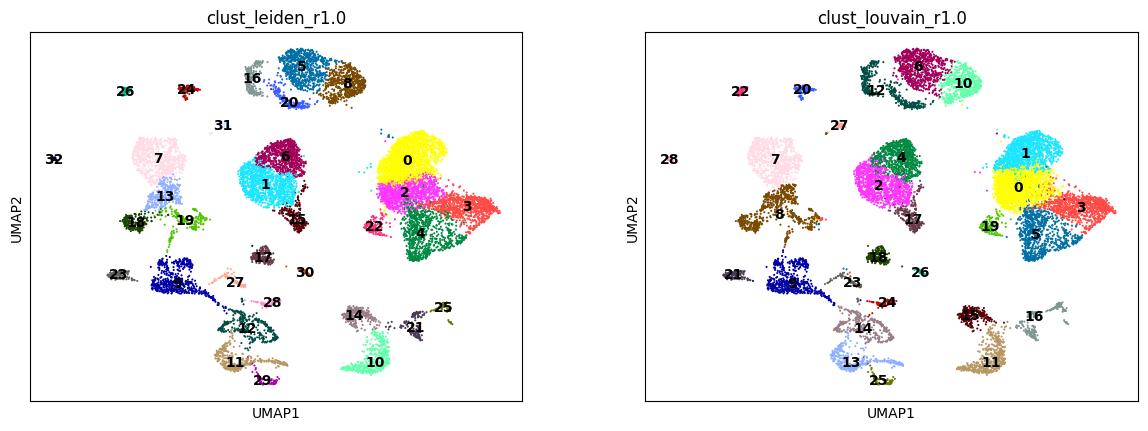

ROC_pred
False    12363
True       836
Name: count, dtype: int64


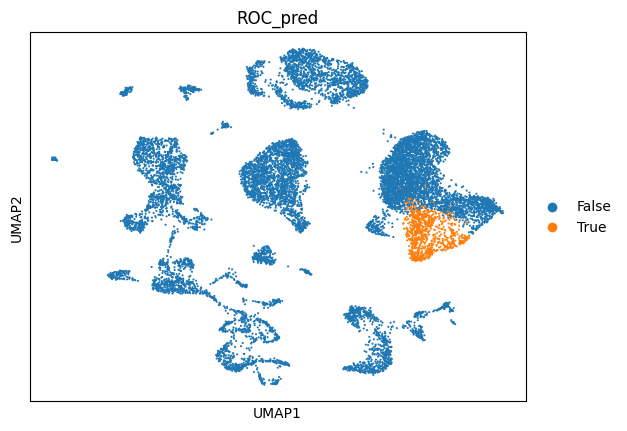

In [ ]:
# Plot expression for overlapping genes and color by the winning cluster
sc.pl.umap(adata_hvg, color=[f"clust_leiden_r1.0", f"clust_louvain_r1.0"], ncols=2, legend_loc="on data")
if plot_genes:
    sc.pl.umap(adata, color=plot_genes, ncols=4, wspace=0.3, size=30)

# Add a boolean ROC label to your main object using the consensus cluster on the key you chose for DE
CLUSTER_KEY_FOR_DE = "clust_leiden_r1.0"  # or whichever key you used
roc_bool = pd.Series(False, index=adata.obs_names)
# Align indices: mark True for cells in adata_hvg that belong to the winning cluster
mask_hvg = (adata_hvg.obs[CLUSTER_KEY_FOR_DE].astype(str) == str(best_cluster))
roc_bool.loc[adata_hvg.obs_names[mask_hvg]] = True
adata.obs["ROC_pred"] = roc_bool.values.astype(bool)

# quick check
print(adata.obs["ROC_pred"].value_counts(dropna=False))
sc.pl.umap(adata, color=["ROC_pred"], wspace=0.3)


### Clustering and Visuals as shown from Supplementary Material

In [ ]:
# ===========================
# DENOISING (from your list): MAGIC + kNN-smoothing
# ===========================
import numpy as np, pandas as pd
import scanpy as sc
import scipy.sparse as sp

# --- MAGIC ---
def run_magic(adata, layer_in=None, layer_out="denoise_magic", t=3, knn=10, n_pca=100):
    """
    MAGIC on (log-normalized) matrix in adata.X or a given layer.
    Writes the imputed matrix to adata.layers[layer_out].
    """
    try:
        import magic
    except Exception as e:
        raise RuntimeError("magic-impute is not installed. Run `pip install magic-impute`") from e

    X = to_dense(adata.layers[layer_in]) if layer_in else to_dense(adata.X)
    mgc = magic.MAGIC(t=t, knn=knn, n_pca=n_pca, random_state=0)
    X_magic = mgc.fit_transform(X)        # (cells x genes)
    adata.layers[layer_out] = np.asarray(X_magic, dtype=np.float32)
    return adata

# --- kNN-smoothing (single pass; neighbors from HVG graph) ---
def knn_smooth(adata_hvg, adata_full, graph_key="connectivities", layer_in=None, layer_out="denoise_knn"):
    """
    Average each cell with its graph neighbors (row-normalized).
    Uses neighbors from adata_hvg (HVG PCA graph), smooths FULL gene space in adata_full.
    """
    G = adata_hvg.obsp.get(graph_key, None)
    if G is None and "connectivities_fuzzy" in adata_hvg.obsp:
        G = adata_hvg.obsp["connectivities_fuzzy"]
    if G is None:
        raise ValueError("No graph found on adata_hvg (connectivities/connectivities_fuzzy missing).")

    G = G.tocsr()
    rs = np.asarray(G.sum(1)).ravel()
    rs[rs == 0] = 1.0
    S = sp.diags(1.0 / rs) @ G  # row-normalized (stochastic)

    X = to_dense(adata_full.layers[layer_in]) if layer_in else to_dense(adata_full.X)
    # Ensure cell order alignment (assumes adata_hvg was sliced from the same adata)
    idx = adata_full.obs_names.get_indexer(adata_hvg.obs_names)
    if (idx < 0).any():
        raise ValueError("Cell indices between adata_hvg and adata_full don't align.")
    X_sub = X[idx, :]                # (n_hvg_cells x genes)
    X_smooth_sub = S @ X_sub         # smooth only HVG cells
    # Write back only for those cells (store compact result)
    out = np.zeros_like(X_sub, dtype=np.float32)
    out[:, :] = X_smooth_sub
    adata_full.layers[layer_out] = out
    return adata_full

# --- Evaluation helper (uses your two-method DE) ---
def evaluate_variant(adata_base, use_layer=None, title="variant"):
    """
    Recompute neighbors/UMAP on HVGs, then cluster & score.
    If adata_base.obs['ROC'] exists with both classes, run ROC markers (Wilcoxon + LogReg).
    """
    ad = adata_base.copy()
    if use_layer:
        if use_layer not in ad.layers:
            print(f"[{title}] layer '{use_layer}' not found; using adata.X")
        else:
            ad.X = to_dense(ad.layers[use_layer])

    if "highly_variable" not in ad.var.columns:
        raise ValueError("No HVG mask found (ad.var['highly_variable']). Run HVG selection first.")
    mask = ad.var["highly_variable"].values
    ad_hvg = ad[:, mask].copy()

    sc.tl.pca(ad_hvg, n_comps=50, svd_solver="arpack")
    sc.pp.neighbors(ad_hvg, n_neighbors=20, n_pcs=50, metric="cosine")
    sc.tl.umap(ad_hvg, min_dist=0.5)

    ad_hvg = add_more_clusterings(ad_hvg, n_pcs=50, key_prefix=f"{title}")
    keys = [k for k in ad_hvg.obs.columns if k.startswith(title)]
    met = clustering_internal_metrics(ad_hvg, keys, emb="X_pca")
    print(f"\n[{title}] Internal metrics:\n", met.sort_values("silhouette", ascending=False))

    # push UMAP back for quick plotting
    ad.obsm["X_umap"] = ad_hvg.obsm["X_umap"]

    # ROC markers (Wilcoxon + LogReg) if available
    dfs = {}; tops = {}
    if "ROC" in ad.obs.columns:
        try:
            dfs, tops = rank_markers_two_only(ad, group_key="ROC", pos_group="True", n_top=50, use_raw=False)
            print(f"[{title}] Top ROC markers (Wilcoxon):", tops.get("wilcoxon", [])[:10])
        except Exception as e:
            print(f"[{title}] ROC marker calling skipped:", e)
    else:
        print(f"[{title}] No 'ROC' column found; skipping ROC marker calling.")
    return ad, ad_hvg, met, dfs, tops

# ===========================
# Build denoised variants and evaluate
# ===========================
# (A) MAGIC on your current working matrix in adata.X (paper-faithful log is fine)
adata = run_magic(adata, layer_in=None, layer_out="denoise_magic", t=3, knn=10, n_pca=100)

# (B) kNN smoothing (neighbors from your existing HVG graph on adata_hvg)
adata = knn_smooth(adata_hvg, adata, graph_key="connectivities", layer_in=None, layer_out="denoise_knn")

# Evaluate: base vs MAGIC vs kNN
ad_base, ad_hvg_base, met_base, dfs_base, tops_base = evaluate_variant(adata, use_layer=None,           title="base")
ad_magic, ad_hvg_magic, met_magic, dfs_magic, tops_magic = evaluate_variant(adata, use_layer="denoise_magic", title="magic")
ad_knn,   ad_hvg_knn,   met_knn,  dfs_knn,  tops_knn   = evaluate_variant(adata, use_layer="denoise_knn",   title="knn")

# Compare consensus ROC markers (≥2 methods) across variants
def _consensus_len(tops):
    return len(consensus_markers_2(tops, min_methods=2)) if tops else 0

print("\nConsensus ROC markers (≥2 methods) counts:",
      {"base": _consensus_len(tops_base),
       "magic": _consensus_len(tops_magic),
       "knn": _consensus_len(tops_knn)})

# Optional quick visuals:
sc.pl.umap(ad_hvg_base,  color=[c for c in ad_hvg_base.obs.columns  if c.startswith("base")],  ncols=3, legend_loc="on data")
sc.pl.umap(ad_hvg_magic, color=[c for c in ad_hvg_magic.obs.columns if c.startswith("magic")], ncols=3, legend_loc="on data")
sc.pl.umap(ad_hvg_knn,   color=[c for c in ad_hvg_knn.obs.columns   if c.startswith("knn")],   ncols=3, legend_loc="on data")


ModuleNotFoundError: No module named 'scanpy'

## Clustering via PCA + Louvain

In [ ]:
sc.pl.umap(adata, color='louvain_pca_r06', frameon=False)

## Clustering via PCA + Leiden

In [ ]:
sc.pl.umap(adata, color='leiden_pca_r06', frameon=False)

In [ ]:
# ========= METRIC HELPERS that match YOUR KEYS =========
import numpy as np, pandas as pd, os
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, rand_score

RESULTS_DIR = RESULTS_DIR if "RESULTS_DIR" in globals() else "./"

# use your exact clustering columns
CLUSTER_COLS = [
    "cluster",             # from sc.tl.leiden(..., key_added="cluster", resolution=0.8)
    "walktrap_k10_s10",
    "leiden_fuzzy_r06",
    "louvain_fuzzy_r06",
    "leiden_pca_r06",
    "louvain_pca_r06",
]

def _present_multi(labels):
    """True if at least 2 clusters present."""
    return (labels is not None) and (len(pd.Series(labels).astype(str).unique()) > 1)

def compute_internal_metrics(adata, cluster_cols=CLUSTER_COLS, emb_key="X_pca", n_dims=30):
    """
    Internal metrics only (no ground-truth needed):
      - Silhouette (on emb_key)
      - Calinski–Harabasz
      - Davies–Bouldin
    """
    if emb_key not in adata.obsm:
        raise ValueError(f"Embedding '{emb_key}' not found in adata.obsm. Available: {list(adata.obsm.keys())}")

    X = adata.obsm[emb_key]
    if X.ndim != 2:
        raise ValueError(f"Embedding '{emb_key}' is not 2D.")
    Xuse = X[:, :min(n_dims, X.shape[1])]

    rows = []
    for col in cluster_cols:
        if col not in adata.obs.columns:
            continue
        labels = adata.obs[col].astype(str).values
        if not _present_multi(labels):
            # silently skip single-cluster results
            continue

        sil = silhouette_score(Xuse, labels)
        ch  = calinski_harabasz_score(Xuse, labels)
        db  = davies_bouldin_score(Xuse, labels)

        rows.append({
            "cluster_key": col,
            "embedding": emb_key,
            "n_dims_used": int(Xuse.shape[1]),
            "n_clusters": int(len(np.unique(labels))),
            "silhouette": float(sil),
            "CalinskiHarabasz": float(ch),
            "DaviesBouldin": float(db),
        })

    df = pd.DataFrame(rows).sort_values(["silhouette","CalinskiHarabasz"], ascending=[False, False])
    out_path = os.path.join(RESULTS_DIR, f"internal_metrics_{emb_key}.csv")
    df.to_csv(out_path, index=False)
    print(f"✓ Internal metrics saved → {out_path}")
    return df

def compute_pairwise_agreement(adata, cluster_cols=CLUSTER_COLS):
    """
    Pairwise ARI/Rand *between your clusterings* (handy when no truth labels).
    Produces two square DataFrames.
    """
    cols = [c for c in cluster_cols if c in adata.obs.columns]
    y = {c: adata.obs[c].astype(str).values for c in cols}
    # keep only multi-cluster labels
    y = {c:v for c,v in y.items() if _present_multi(v)}

    if len(y) < 2:
        print("Not enough multi-cluster label sets for pairwise comparison.")
        return None, None

    idx = list(y.keys())
    ARI  = pd.DataFrame(index=idx, columns=idx, dtype=float)
    RAND = pd.DataFrame(index=idx, columns=idx, dtype=float)
    for a in idx:
        for b in idx:
            if a == b:
                ARI.loc[a,b]  = 1.0
                RAND.loc[a,b] = 1.0
            else:
                ARI.loc[a,b]  = adjusted_rand_score(y[a], y[b])
                RAND.loc[a,b] = rand_score(y[a], y[b])

    ARI_path  = os.path.join(RESULTS_DIR, "pairwise_ARI_between_clusterings.csv")
    RAND_path = os.path.join(RESULTS_DIR, "pairwise_Rand_between_clusterings.csv")
    ARI.to_csv(ARI_path)
    RAND.to_csv(RAND_path)
    print(f"✓ Pairwise ARI saved → {ARI_path}")
    print(f"✓ Pairwise Rand saved → {RAND_path}")
    return ARI, RAND

# ================== RUN with YOUR current results ==================
# Internal metrics on PCA (best for distance-based scores)
internal_pca = compute_internal_metrics(adata, cluster_cols=CLUSTER_COLS, emb_key="X_pca", n_dims=30)

# (Optional) also score on UMAP as an alternative view
if "X_umap" in adata.obsm:
    internal_umap = compute_internal_metrics(adata, cluster_cols=CLUSTER_COLS, emb_key="X_umap", n_dims=2)

# Pairwise agreement between your clusterings (no ground-truth needed)
ari_mat, rand_mat = compute_pairwise_agreement(adata, cluster_cols=CLUSTER_COLS)

# Quick peek
display(internal_pca.head())
if "internal_umap" in locals():
    display(internal_umap.head())
if ari_mat is not None:
    display(ari_mat)


### Metrics for clustering

In [ ]:
# =========================
# Helpers for reuse
# =========================
import os
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Where to save
DENOISE_DIR = os.path.join(RESULTS_DIR, "denoise_runs")
os.makedirs(DENOISE_DIR, exist_ok=True)

def ensure_raw(adata):
    """Make sure adata.raw exists (needed for use_raw=True marker calls & scoring)."""
    if adata.raw is None:
        adata.raw = adata

def clustering_metrics(adata, cluster_keys, emb_key="X_pca", reference_key=None, n_pcs=30):
    rows = []
    for ck in cluster_keys:
        if ck not in adata.obs.columns:
            continue
        labs = adata.obs[ck].astype(str).values
        if len(np.unique(labs)) <= 1:
            continue
        X = adata.obsm.get(emb_key, None)
        if X is None:
            continue
        Xm = X[:, :min(n_pcs, X.shape[1])] if X.ndim == 2 else X
        sil = silhouette_score(Xm, labs)
        ch  = calinski_harabasz_score(Xm, labs)
        db  = davies_bouldin_score(Xm, labs)
        ari = np.nan
        rs  = np.nan
        if reference_key is not None and reference_key in adata.obs.columns:
            yref = adata.obs[reference_key].astype(str).values
            ari = adjusted_rand_score(yref, labs)
            rs  = rand_score(yref, labs)
        rows.append({
            "method": ck, "n_clusters": int(np.unique(labs).size),
            "silhouette": float(sil), "CalinskiHarabasz": float(ch), "DaviesBouldin": float(db),
            "ARI_vs_ref": float(ari) if not np.isnan(ari) else np.nan,
            "RandIndex_vs_ref": float(rs) if not np.isnan(rs) else np.nan,
            "embedding": emb_key
        })
    return pd.DataFrame(rows).sort_values("silhouette", ascending=False)

def compute_embedding_and_clusters(
    adata, variant_label, use_rep=None, n_pcs=50, nn=20, resolution=0.6
):
    """
    Recompute PCA neighbors/UMAP & Leiden/Louvain using either:
      - raw expression (use_rep=None) with PCA, or
      - a precomputed embedding stored in adata.obsm[use_rep] (e.g. scVI latent)
    Adds cluster keys: 'leiden_pca_r06' and 'louvain_pca_r06' (suffixes kept for consistency).
    """
    ad = adata.copy()
    if use_rep is None:
        # Standard PCA workflow
        sc.pp.scale(ad, max_value=10)
        sc.tl.pca(ad, n_comps=n_pcs)
        sc.pp.neighbors(ad, n_neighbors=nn, n_pcs=min(30, n_pcs), metric="euclidean")
        emb_key = "X_pca"
    else:
        # Neighbors on provided representation (e.g., X_scVI latent)
        if use_rep not in ad.obsm:
            raise KeyError(f"{use_rep} not found in adata.obsm")
        sc.pp.neighbors(ad, n_neighbors=nn, use_rep=use_rep)
        # also compute a PCA for metric compatibility if you want silhouette on PCA
        sc.tl.pca(ad, n_comps=n_pcs)
        emb_key = use_rep

    sc.tl.umap(ad, min_dist=0.5, random_state=0)
    sc.tl.leiden(ad, resolution=resolution, key_added="leiden_pca_r06", random_state=0)
    sc.tl.louvain(ad, resolution=resolution, key_added="louvain_pca_r06", random_state=0)

    # Quick plots (saved)
    fig_dir = os.path.join(DENOISE_DIR, variant_label, "figures")
    os.makedirs(fig_dir, exist_ok=True)
    sc.pl.umap(ad, color=["leiden_pca_r06","louvain_pca_r06"], ncols=2, frameon=False,
               save=None, show=False)
    # Manually save current figure(s)
    import matplotlib.pyplot as plt
    plt.savefig(os.path.join(fig_dir, f"umap_clusters_{variant_label}.png"), dpi=200, bbox_inches="tight")
    plt.close('all')

    return ad, emb_key

# ---------- DENOISING 1: MAGIC (expression imputation) ----------
def denoise_magic(adata):
    """
    Returns a copy with MAGIC-imputed expression in .X and leaves original in .layers['counts']/.raw.
    """
    ensure_raw(adata)
    ad = adata.copy()
    import magic as _magic
    M = _magic.MAGIC()
    ad.X = M.fit_transform(ad.X)  # replace expression matrix with MAGIC-imputed
    return ad

# ---------- DENOISING 2: scVI (latent denoising) ----------
def denoise_scvi(adata, n_latent=10, max_epochs=100):
    """
    Trains scVI and returns a copy with:
      - latent embedding in ad.obsm['X_scVI']
      - normalized expression in ad.layers['scvi_denoised']
    """
    ensure_raw(adata)
    ad = adata.copy()
    import scvi
    # minimal setup; you can add batch_key=... if you want to condition on batches
    scvi.model.SCVI.setup_anndata(ad)   # if you have a batch column: setup_anndata(ad, batch_key='sample')
    model = scvi.model.SCVI(ad, n_latent=n_latent)
    model.train(max_epochs=max_epochs, early_stopping=True)
    ad.obsm["X_scVI"] = model.get_latent_representation()
    ad.layers["scvi_denoised"] = model.get_normalized_expression()
    return ad

def save_metrics(df, variant_label):
    out = os.path.join(DENOISE_DIR, variant_label, "metrics.csv")
    os.makedirs(os.path.dirname(out), exist_ok=True)
    df.to_csv(out, index=False)
    return out

# =========================
# Run three variants: original, MAGIC, scVI
# =========================

# 0) ORIGINAL (your current adata as-is)
orig_ad, orig_emb_key = compute_embedding_and_clusters(
    adata, variant_label="original", use_rep=None, n_pcs=50, nn=20, resolution=0.6
)
orig_metrics = clustering_metrics(
    orig_ad, ["leiden_pca_r06", "louvain_pca_r06"], emb_key="X_pca",
    reference_key="cluster" if "cluster" in adata.obs.columns else None, n_pcs=30
)
print("Original metrics:\n", orig_metrics)
save_metrics(orig_metrics, "original")

# 1) MAGIC
adata_magic = denoise_magic(adata)
magic_ad, magic_emb_key = compute_embedding_and_clusters(
    adata_magic, variant_label="magic", use_rep=None, n_pcs=50, nn=20, resolution=0.6
)
magic_metrics = clustering_metrics(
    magic_ad, ["leiden_pca_r06", "louvain_pca_r06"], emb_key="X_pca",
    reference_key="cluster" if "cluster" in adata.obs.columns else None, n_pcs=30
)
print("MAGIC metrics:\n", magic_metrics)
save_metrics(magic_metrics, "magic")

# 2) scVI (neighbors/UMAP on the latent; also compute PCA for compatibility)
adata_scvi = denoise_scvi(adata, n_latent=10, max_epochs=100)
scvi_ad, scvi_emb_key = compute_embedding_and_clusters(
    adata_scvi, variant_label="scvi", use_rep="X_scVI", n_pcs=50, nn=20, resolution=0.6
)
# silhouette computed on the representation we clustered on (X_scVI)
scvi_metrics = clustering_metrics(
    scvi_ad, ["leiden_pca_r06", "louvain_pca_r06"], emb_key="X_scVI",
    reference_key="cluster" if "cluster" in adata.obs.columns else None, n_pcs=10
)
print("scVI metrics:\n", scvi_metrics)
save_metrics(scvi_metrics, "scvi")

# =========================
# Optional: ROC score overlays for each variant
# (reuses your ROC seed list; you can skip this block if not needed)
# =========================
def map_seed_genes_to_varnames(adata, seed):
    def norm(g): return g.replace(".L","").replace(".S","").upper()
    var_norm = {v: norm(str(v)) for v in adata.var_names}
    lookup = {}
    for orig, nn in var_norm.items():
        if nn not in lookup: lookup[nn] = orig
    out = [lookup[norm(g)] for g in seed if norm(g) in lookup]
    return out

roc_seed = ["TP63","LEF1","FGF10","RSPO2","FGF7","BMP5","FGFR4","WNT5A","EGFL6","FREM2","IGFBP2","LPAR3","NID2","PLTP"]

def add_roc_score_and_plot(ad, variant_label, cluster_key="leiden_pca_r06"):
    ensure_raw(ad)
    genes = map_seed_genes_to_varnames(ad, roc_seed)
    if len(genes) == 0:
        print(f"[{variant_label}] No ROC genes found in var_names; skipping ROC overlay.")
        return
    sc.tl.score_genes(ad, gene_list=genes, score_name="roc_score", use_raw=True)
    # UMAP overlays
    fig_dir = os.path.join(DENOISE_DIR, variant_label, "figures")
    os.makedirs(fig_dir, exist_ok=True)
    sc.pl.umap(ad, color=[cluster_key, "roc_score"], frameon=False, ncols=2, show=False)
    import matplotlib.pyplot as plt
    plt.savefig(os.path.join(fig_dir, f"umap_{variant_label}_cluster_and_ROCscore.png"), dpi=200, bbox_inches="tight")
    plt.close('all')

add_roc_score_and_plot(orig_ad,  "original", cluster_key="leiden_pca_r06")
add_roc_score_and_plot(magic_ad, "magic",    cluster_key="leiden_pca_r06")
add_roc_score_and_plot(scvi_ad,  "scvi",     cluster_key="leiden_pca_r06")

print("\nAll outputs saved under:", DENOISE_DIR)


## Marker Selection

In [ ]:
# choose cluster(s) with TP63+LEF1+ enrichment
def pick_gene(name):
    for g in (f"{name}.L", f"{name}.S", name, name.upper(), name.capitalize()):
        if g in adata.var_names: return g
    return None

tp63 = pick_gene("tp63"); lef1 = pick_gene("lef1")
assert tp63 and lef1, "TP63/LEF1 not found in var_names (check casing/alleles)."

X2 = adata[:, [tp63, lef1]].X
X2 = X2.A if sp.issparse(X2) else X2
tp63_pos = X2[:,0] > np.percentile(X2[:,0], 75)
lef1_pos = X2[:,1] > np.percentile(X2[:,1], 75)
adata.obs["TP63_LEF1_pos"] = tp63_pos & lef1_pos

cluster_key = "louvain_pca_r06"   # or "walktrap_k10_s10" / "leiden_fuzzy_r06"
adata.obs[cluster_key] = adata.obs[cluster_key].astype(str).astype("category")

frac = adata.obs.groupby(cluster_key)["TP63_LEF1_pos"].mean().sort_values(ascending=False)
roc_clusters = [frac.index[0]]   # take top cluster (or z-score > 1 to include more)
print("ROC cluster(s):", roc_clusters)

# build a categorical with BOTH classes present
adata.obs["is_ROC"] = adata.obs[cluster_key].isin(roc_clusters)
adata.obs["roc_group"] = pd.Categorical(np.where(adata.obs["is_ROC"], "ROC", "rest"),
                                        categories=["rest","ROC"])
print(adata.obs["roc_group"].value_counts())  # must show counts for both rest and ROC


In [ ]:
# sanity: both classes must be present (you already showed they are)
print(adata.obs["roc_group"].value_counts())

# 1) Wilcoxon (keep one-vs-rest)
sc.tl.rank_genes_groups(
    adata,
    groupby="roc_group",
    groups=["ROC"],
    reference="rest",
    method="wilcoxon",
    key_added="rg_wilc",
)
wilc = sc.get.rank_genes_groups_df(adata, key="rg_wilc", group="ROC")

# 2) Logistic regression (NO groups/reference here!)
sc.tl.rank_genes_groups(
    adata,
    groupby="roc_group",
    method="logreg",
    key_added="rg_logr_all",
    max_iter=5000,
    solver="liblinear",   # robust for binary, small minority class
    penalty="l2",
    C=1.0,
)

logr_all = sc.get.rank_genes_groups_df(adata, key="rg_logr_all")
print("Groups present in logreg:", logr_all["group"].unique())

logr = logr_all[logr_all["group"] == "ROC"].copy()
# (Optional) keep top-K
logr_top = logr.sort_values("scores", ascending=False).head(50)


In [ ]:
# Wilcoxon (one-vs-rest)
sc.tl.rank_genes_groups(adata, groupby="roc_group", reference="rest",
                        groups=["ROC"], method="wilcoxon", key_added="rg_wilc")
wilc = sc.get.rank_genes_groups_df(adata, key="rg_wilc", group="ROC")

# Logistic regression (multivariate)
sc.tl.rank_genes_groups(adata, groupby="roc_group", reference="rest",
                        groups=["ROC"], method="logreg", key_added="rg_logr", max_iter=5000)
logr = sc.get.rank_genes_groups_df(adata, key="rg_logr", group="ROC")

# Optional: per-gene AUC (univariate classifier)
X = adata.X.A if sp.issparse(adata.X) else adata.X
y = (adata.obs["roc_group"].values == "ROC").astype(int)
rows=[]
for j,g in enumerate(adata.var_names):
    xg = X[:, j]
    if np.std(xg)==0:
        continue
    auc = roc_auc_score(y, xg)
    if auc < 0.5: auc = 1 - auc   # orient so "higher in ROC" → larger AUC
    rows.append((g, auc))
auc = pd.DataFrame(rows, columns=["gene","AUC"]).sort_values("AUC", ascending=False)

# Save tables (handy for your report)
wilc.to_csv(OUT_TAB+"markers_wilcoxon.csv", index=False)
logr.to_csv(OUT_TAB+"markers_logreg.csv", index=False)
auc.head(200).to_csv(OUT_TAB+"markers_auc.csv", index=False)


In [ ]:
sc.pl.umap(adata, color=[cluster_key, "TP63_LEF1_pos", "is_ROC"], ncols=3, frameon=False)


In [ ]:
import numpy as np, pandas as pd, scipy.sparse as sp
from sklearn.metrics import roc_auc_score

# 0) Make a clean categorical group: "rest" vs "ROC"
# (assumes you already set a boolean flag adata.obs["is_ROC"])
adata.obs["is_ROC"] = adata.obs["is_ROC"].astype(bool)
adata.obs["roc_group"] = pd.Categorical(
    np.where(adata.obs["is_ROC"], "ROC", "rest"),
    categories=["rest", "ROC"]   # reference first
)

# 1) Wilcoxon (ROC vs rest)
sc.tl.rank_genes_groups(
    adata,
    groupby="roc_group",
    reference="rest",
    groups=["ROC"],              # only test ROC
    method="wilcoxon",
    key_added="rg_wilc"
)
wilc = sc.get.rank_genes_groups_df(adata, key="rg_wilc", group="ROC")

# 2) Logistic regression
sc.tl.rank_genes_groups(
    adata,
    groupby="roc_group",
    reference="rest",
    groups=["ROC"],
    method="logreg",
    max_iter=5000,
    key_added="rg_logr"
)
logr = sc.get.rank_genes_groups_df(adata, key="rg_logr", group="ROC")

# 3) (Optional) per-gene AUC (one-vs-rest, high-in-ROC direction)
X = adata.X.A if sp.issparse(adata.X) else adata.X
y = (adata.obs["roc_group"].values == "ROC").astype(int)

rows = []
for j, g in enumerate(adata.var_names):
    xg = X[:, j]
    if np.std(xg) == 0:
        continue
    auc = roc_auc_score(y, xg)
    if auc < 0.5:
        auc = 1 - auc        # force "higher in ROC" orientation
    rows.append((g, auc))

auc = (pd.DataFrame(rows, columns=["gene", "AUC"])
         .sort_values("AUC", ascending=False))


For Clustering use Leiden or Louvain clustering after reducing dimensionality using PCA,  Try Seurat or Hamony or some other method supported by ScanPy

For marker selection Wilcoxon + Logistic Regression